In [10]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

#### Load matlab data

In [11]:
feats = scipy.io.loadmat('output/feats4T_.1R.mat')
labels = scipy.io.loadmat('output/labels4T_.1R.mat')

feats = feats['features']
labels = labels['lp']

feats.shape, labels.shape

((48, 4, 4, 42581), (3, 42581))

In [12]:
X = torch.Tensor(feats)
Y = torch.Tensor(labels)

Y = Y.T

X = X.T
X = torch.flatten(X, start_dim=1, end_dim=2)
X = X[:, None, :, :]

X.shape, Y.shape

(torch.Size([42581, 1, 16, 48]), torch.Size([42581, 3]))

### sample shape: (minibatch_size, 1, 16, 48)

In [13]:
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Define models and functions

In [14]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(p=0.2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(p=0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(p=0.2),
        )
        linear_in_dim = int(16/2/2/2*48/2/2/2*64)
        self.linear1 = nn.Linear(linear_in_dim, 100)
        # self.dropout1 = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(100, 20)
        # self.dropout2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(20, 3)

    
    def forward(self, x):
        out = self.seq(x)
        out = out.view(out.size(0), -1) # flatten to (batch size, int)
        out = F.relu(self.linear1(out))
        # out = self.dropout1(out)
        out = F.relu(self.linear2(out))
        # out = self.dropout2(out)
        out = self.linear3(out)
        return out
        
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )
    def forward(self, x):
        return self.seq(x)

def EucLoss(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    assert a.shape == b.shape
    assert b.shape[-1] == 3
    return torch.sum((a-b).square(), dim=-1).sqrt().mean()

def EucLossSquared(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    assert a.shape == b.shape
    assert b.shape[-1] == 3
    return torch.sum((a-b).square(), dim=-1).mean()


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)
model

SimpleNN(
  (seq): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=768, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [16]:
crit = EucLoss
# crit = nn.L1Loss()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.RMSprop(model.parameters())


#### Training/Evaluating NN

In [17]:
num_epochs = 300
loss_tracker = np.zeros((num_epochs, 2))

num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0

    
    model = model.train()
    
    for batch_idx, (ft, lbl) in enumerate(train_loader):
        ft, lbl = ft.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(ft)
        loss = crit(output, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * ft.shape[0]
    train_loss /= len(train_dataset)
    loss_tracker[epoch, 0] = train_loss
        
        
    model = model.eval()
    
    with torch.no_grad():
        for batch_idx, (ft, lbl) in enumerate(test_loader):
            ft, lbl = ft.to(device), lbl.to(device)
            output = model(ft)
            loss = crit(output, lbl)
            test_loss += loss.item() * ft.shape[0]
    test_loss /= len(test_dataset)
    loss_tracker[epoch, 1] = test_loss
            
    print('Epoch {} | Training loss = {} | Test loss = {}'.format(epoch, train_loss, test_loss))

Epoch 0 | Training loss = 1.78543444332689 | Test loss = 1.7143188970419558
Epoch 1 | Training loss = 1.5476854290968938 | Test loss = 1.4926971497775887
Epoch 2 | Training loss = 1.4484048044250402 | Test loss = 1.44744277591085
Epoch 3 | Training loss = 1.3835474659210643 | Test loss = 1.378822694883473
Epoch 4 | Training loss = 1.3280487829891938 | Test loss = 1.3664935801081552
Epoch 5 | Training loss = 1.2986856048350157 | Test loss = 1.3438379240803027
Epoch 6 | Training loss = 1.277626221870917 | Test loss = 1.338696424944574
Epoch 7 | Training loss = 1.2610605882892814 | Test loss = 1.3004691629352685
Epoch 8 | Training loss = 1.2460267318420535 | Test loss = 1.27246720952944
Epoch 9 | Training loss = 1.2349496252271366 | Test loss = 1.28259090718297
Epoch 10 | Training loss = 1.2234049147986201 | Test loss = 1.3325111493826949
Epoch 11 | Training loss = 1.2159820711069569 | Test loss = 1.3103452502414488
Epoch 12 | Training loss = 1.2102881095509062 | Test loss = 1.28447853075

### Notes:

CNN seemed to help accuracy, as well as more linear layers. However, it is overfitting heavily. Batchnorm didn't really make a difference, dropout seems to make things worse. try running on stampede

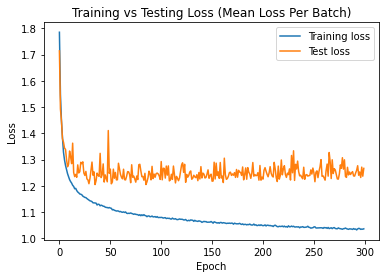

In [18]:
img_dir = Path('./loss_plots')
img_dir.mkdir(parents=True, exist_ok=True)

plt.figure()
plt.plot(loss_tracker)
plt.title('Training vs Testing Loss (Mean Loss Per Batch)')
plt.legend(['Training loss', 'Test loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(img_dir / '4T_1R_Matthew-NN_rmsprop.png')

In [11]:
# save model
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_dir / 'large_dataset_9cm_overfit.pth')